In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

In [2]:
os.chdir("..")
print(os.getcwd())

C:\Work\ASTAR\autoBearing


In [3]:
from data_scripts.FEMTO import FEMTO

In [4]:
# Download the raw FEMTO files if it is not found
class arguments():
    def __init__(self):
        self.raw_dir = 'raw_data'
        self.processed_dir = 'processed_data'
        self.window_size = 1024
        self.stride = 0.2

        self.fttp = True
        self.normalise = True
        
args = arguments()
FEMTO_class = FEMTO(args)
FEMTO_class.download_data()

In [5]:
# Reading the first snapshot of bearing1_1
signal_csv = pd.read_csv(os.path.join(FEMTO_class.download_path,  'Bearing1_1', 'acc_00001.csv'), header=None)
signal_csv

,0,1,2,3,4,5
0,9,39,39,65664.0,0.552,-0.146
1,9,39,39,65703.0,0.501,-0.480
2,9,39,39,65742.0,0.138,0.435
3,9,39,39,65781.0,-0.423,0.240
4,9,39,39,65820.0,-0.802,0.020
...,...,...,...,...,...,...
2555,9,39,39,165470.0,0.044,-0.094
2556,9,39,39,165510.0,-0.456,0.486
2557,9,39,39,165550.0,-0.885,-0.154
2558,9,39,39,165580.0,-0.230,-0.762


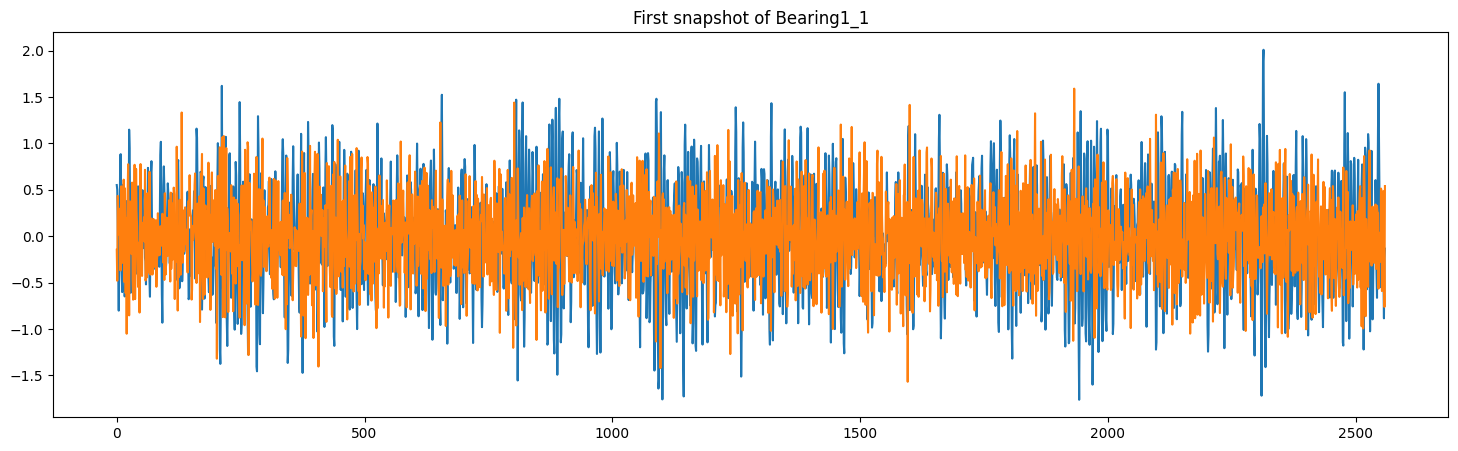

RMS of snapshot x: 0.56174565773522, y: 0.4358014232064301
combined RMS: 0.7109719153757939


In [46]:
x_signal = np.array(signal_csv[4])
y_signal = np.array(signal_csv[5])

plt.figure(figsize=(18,5))
plt.title(f'First snapshot of Bearing1_1')
plt.plot(x_signal, label='x')
plt.plot(y_signal, label='y')

plt.show()

x_rms, y_rms = np.sqrt(np.mean(x_signal ** 2)), np.sqrt(np.mean(y_signal ** 2))
combined_rms = np.sqrt(x_rms ** 2 + y_rms ** 2)

print(f'RMS of snapshot x: {x_rms}, y: {y_rms}')
print(f'combined RMS: {combined_rms}')

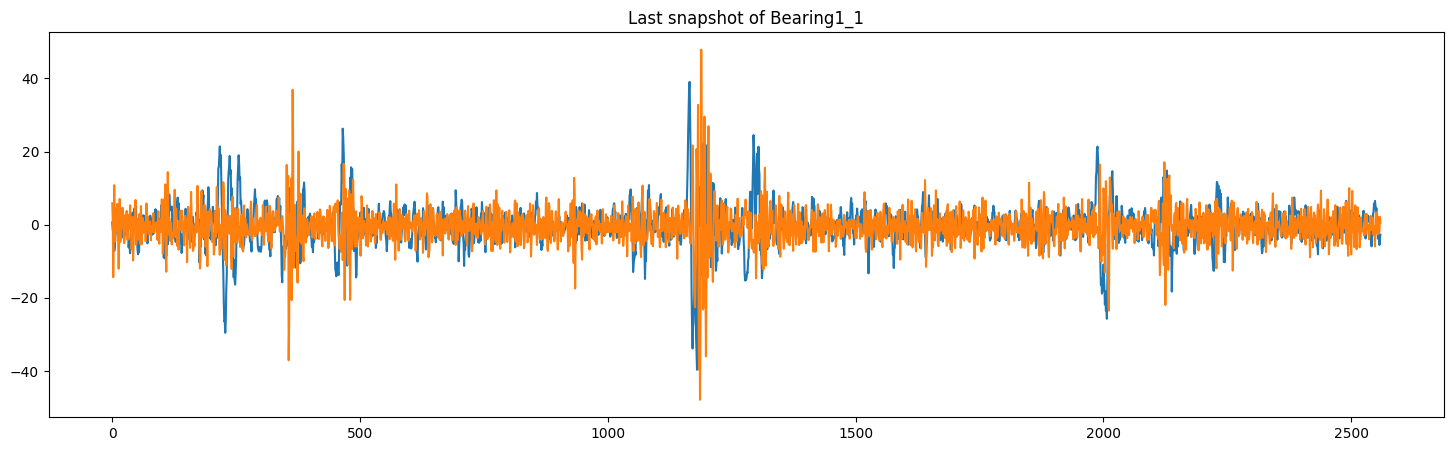

RMS of snapshot x: 5.607562065667441, y: 5.119619129930163
combined RMS: 7.5931055804498975


In [7]:
# Reading last snapshot of bearing1_1
signal_csv = pd.read_csv(os.path.join(FEMTO_class.download_path, 'Bearing1_1', 'acc_02803.csv'), header=None)

x_signal = np.array(signal_csv[4])
y_signal = np.array(signal_csv[5])

plt.figure(figsize=(18,5))
plt.title(f'Last snapshot of Bearing1_1')
plt.plot(x_signal, label='x')
plt.plot(y_signal, label='y')

plt.show()

x_rms, y_rms = np.sqrt(np.mean(x_signal ** 2)), np.sqrt(np.mean(y_signal ** 2))
combined_rms = np.sqrt(x_rms ** 2 + y_rms ** 2)

print(f'RMS of snapshot x: {x_rms}, y: {y_rms}')
print(f'combined RMS: {combined_rms}')

In [8]:
# Checks if the list is already sorted chronologically
temp_list = []
for snapshot in os.listdir(os.path.join(FEMTO_class.download_path, 'Bearing1_1')):
    # Removes _ and . in the string and convert it to integer. So 'acc_00001.csv turns into 00001
    temp_list.append(int(snapshot.split('_')[1].split('.')[0]))

if(temp_list == sorted(temp_list)):
    print('File is sorted chronologically, proceed with analysis')
else:
    raise NotImplemented('File list is not sorted, implement a function to sort the list chronologically')

File is sorted chronologically, proceed with analysis


# Identifying begining of wear-out period

In [9]:
def read_bearing_signal(bearing_name):
    x_list, y_list = [], []
    for file_name in os.listdir(os.path.join(FEMTO_class.download_path, bearing_name)):
        x, y = get_x_y(bearing_name, file_name)
        x_list.append(x)
        y_list.append(x)
        
    # Convert the list into a np array
    x_signal, y_signal = np.vstack(x_list), np.vstack(y_list)
    
    return x_signal, y_signal
    
def get_x_y(bearing_name, file_name):
    signal = pd.read_csv(os.path.join(FEMTO_class.download_path,  bearing_name, file_name), header=None)
    return np.array(signal[4]), np.array(signal[5])

In [10]:
# Training data
bearing1_1_x, bearing1_1_y = read_bearing_signal('bearing1_1')
bearing1_2_x, bearing1_2_y = read_bearing_signal('bearing1_2')
bearing2_1_x, bearing2_1_y = read_bearing_signal('bearing2_1')
bearing2_2_x, bearing2_2_y = read_bearing_signal('bearing2_2')
bearing3_1_x, bearing3_1_y = read_bearing_signal('bearing3_1')
bearing1_1_x, bearing1_1_y

(array([[ 5.520e-01,  5.010e-01,  1.380e-01, ..., -8.850e-01, -2.300e-01,
         -1.340e-01],
        [-1.400e-01, -1.620e-01, -2.000e-03, ..., -3.060e-01,  8.200e-02,
          6.690e-01],
        [ 2.070e-01, -9.900e-02, -1.510e-01, ..., -5.440e-01, -1.780e-01,
          8.540e-01],
        ...,
        [-4.800e-02,  2.813e+00,  5.034e+00, ..., -1.724e+00, -1.162e+00,
          1.720e-01],
        [-7.488e+00, -6.070e-01,  1.124e+00, ..., -2.767e+00, -1.224e+00,
         -2.830e+00],
        [ 6.560e-01, -1.217e+00, -2.192e+00, ..., -5.507e+00, -3.578e+00,
         -2.709e+00]]),
 array([[ 5.520e-01,  5.010e-01,  1.380e-01, ..., -8.850e-01, -2.300e-01,
         -1.340e-01],
        [-1.400e-01, -1.620e-01, -2.000e-03, ..., -3.060e-01,  8.200e-02,
          6.690e-01],
        [ 2.070e-01, -9.900e-02, -1.510e-01, ..., -5.440e-01, -1.780e-01,
          8.540e-01],
        ...,
        [-4.800e-02,  2.813e+00,  5.034e+00, ..., -1.724e+00, -1.162e+00,
          1.720e-01],
        [-7.

In [16]:
# Calculate the RMS of each snapshot
def calculate_RMS(np_array):
    rms_list = []
    for snapshot in np_array:
        rms_list.append(np.sqrt(np.mean(snapshot ** 2)))
    return np.array(rms_list)

def calculate_x_y_RMS(x, y):
    x_rms, y_rms = calculate_RMS(x), calculate_RMS(y)
    combined_rms = np.sqrt(x_rms ** 2 + y_rms ** 2)
    return combined_rms

In [12]:
bearing1_1_rms = calculate_x_y_RMS(bearing1_1_x, bearing1_1_y)
bearing1_2_rms = calculate_x_y_RMS(bearing1_2_x, bearing1_2_y)
bearing2_1_rms = calculate_x_y_RMS(bearing2_1_x, bearing2_1_y)
bearing2_2_rms = calculate_x_y_RMS(bearing2_2_x, bearing2_2_y)
bearing3_1_rms = calculate_x_y_RMS(bearing3_1_x, bearing3_1_y)

bearing1_1_rrms = bearing1_1_rms / bearing1_1_rms.mean()
bearing1_2_rrms = bearing1_2_rms / bearing1_2_rms.mean()
bearing2_1_rrms = bearing2_1_rms / bearing2_1_rms.mean()
bearing2_2_rrms = bearing2_2_rms / bearing2_2_rms.mean()
bearing3_1_rrms = bearing3_1_rms / bearing3_1_rms.mean()

bearing1_1_rrms

array([0.83050318, 0.79112784, 0.78528176, ..., 7.58484431, 9.31017119,
       8.29040344])

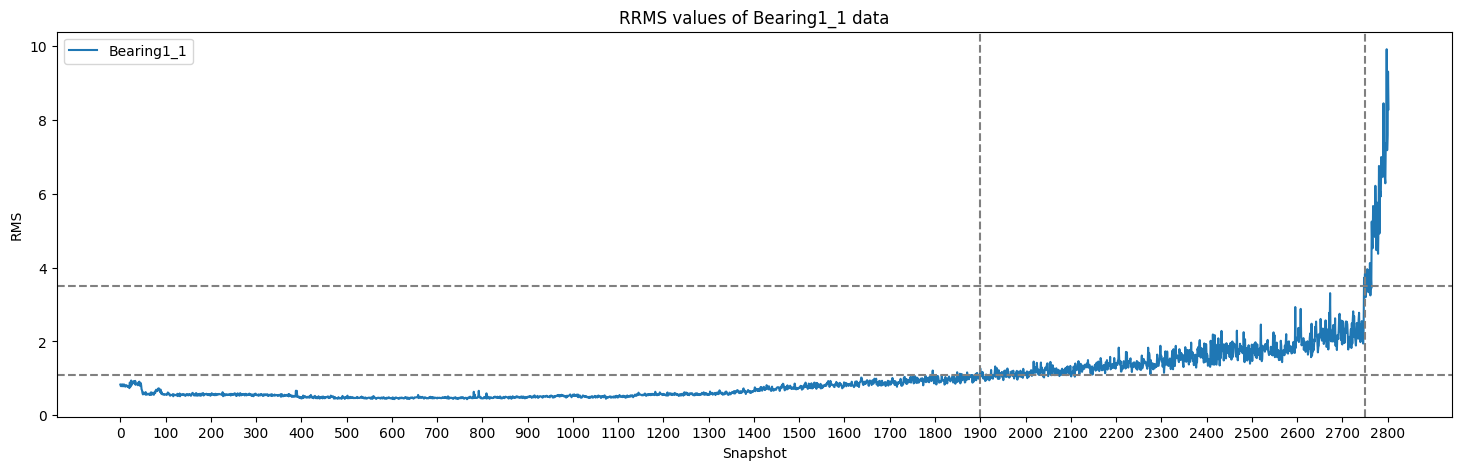

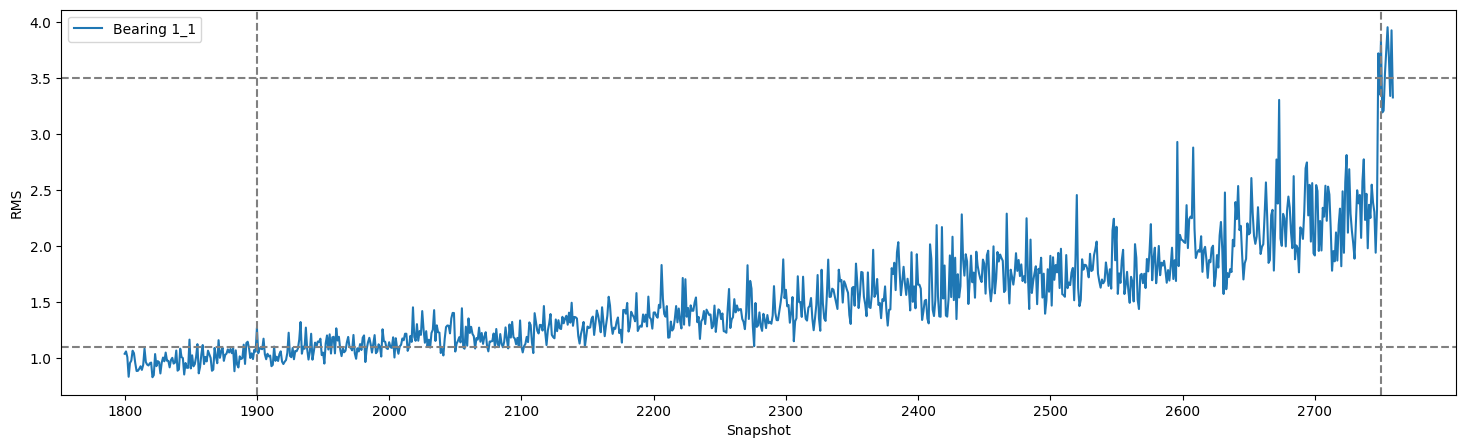

In [47]:
# Plot the RRMS values for bearing1_1 (wear-in begins from 1900 to 2751)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of Bearing1_1 data')
plt.xlabel("Snapshot")
plt.ylabel("RMS")
plt.plot(bearing1_1_rrms, label='Bearing1_1')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1900, linestyle='dashed', color='grey')
plt.axvline(x=2750, linestyle='dashed', color='grey')
plt.xticks(np.arange(0, 2803, 100))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RMS")
plt.plot(np.arange(1800,2760), bearing1_1_rrms[1800:2760], label='Bearing 1_1')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1900, linestyle='dashed', color='grey')
plt.axvline(x=2750, linestyle='dashed', color='grey')
plt.xticks(np.arange(1800, 2760, 100))
plt.legend() 
plt.show()

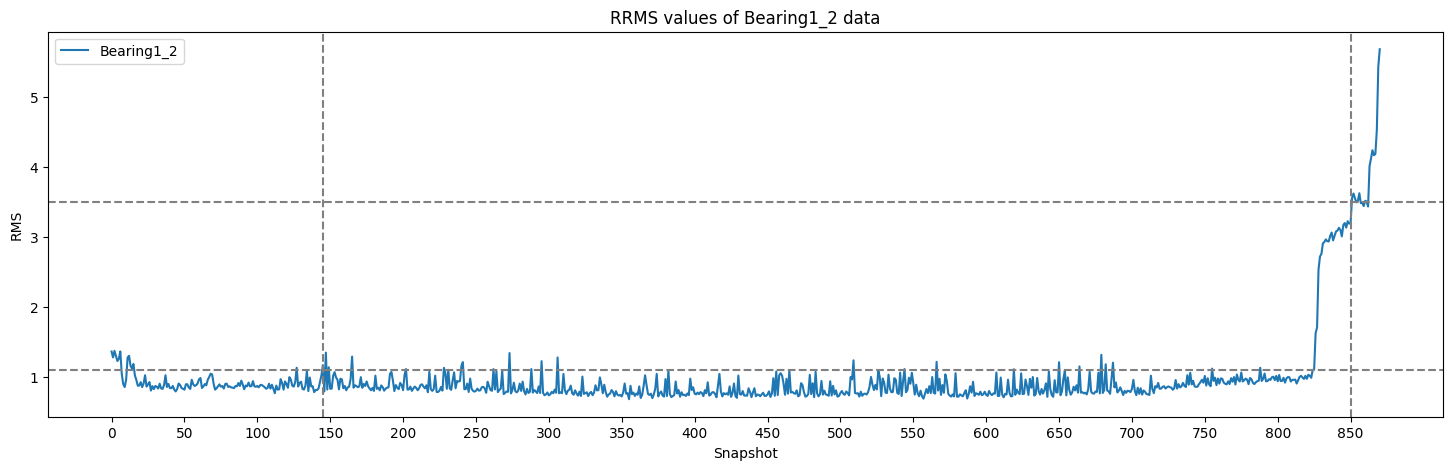

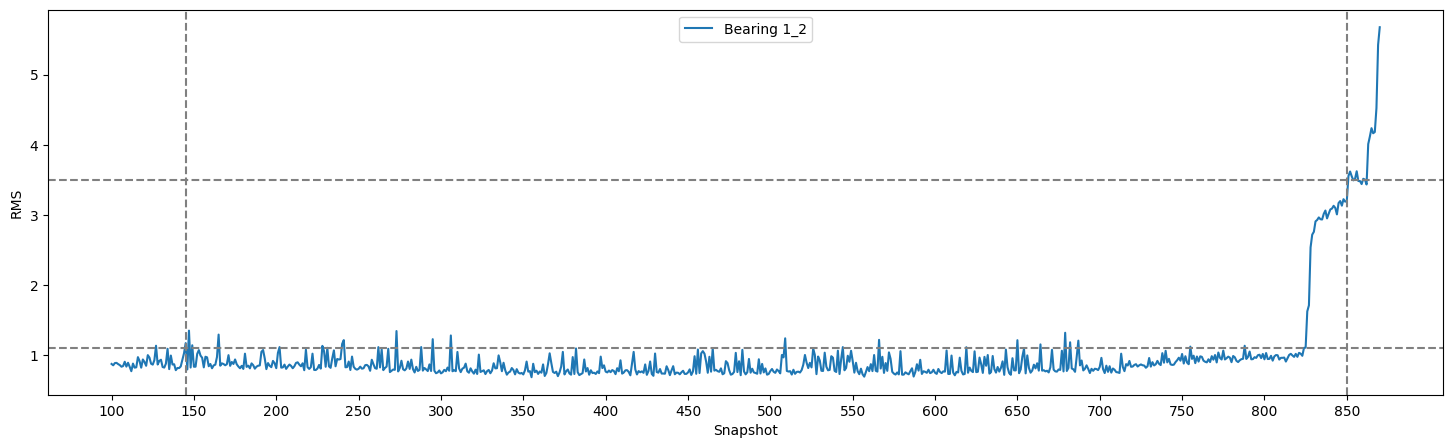

In [46]:
# Plot the RRMS values for bearing1_2 (wear-in begins from 145 to 850)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of Bearing1_2 data')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing1_2_rrms, label='Bearing1_2')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=145, linestyle='dashed', color='grey')
plt.axvline(x=850, linestyle='dashed', color='grey')
plt.xticks(np.arange(0, 871, 50))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(100,871), bearing1_2_rrms[100:871], label='Bearing 1_2')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=145, linestyle='dashed', color='grey')
plt.axvline(x=850, linestyle='dashed', color='grey')
plt.xticks(np.arange(100, 871, 50))
plt.legend() 
plt.show()

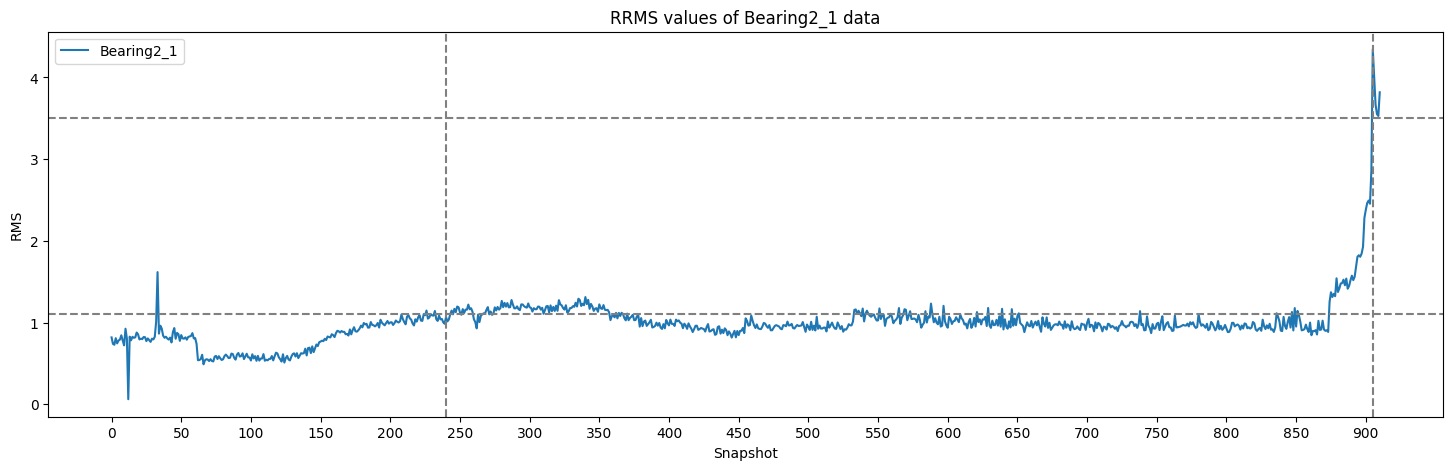

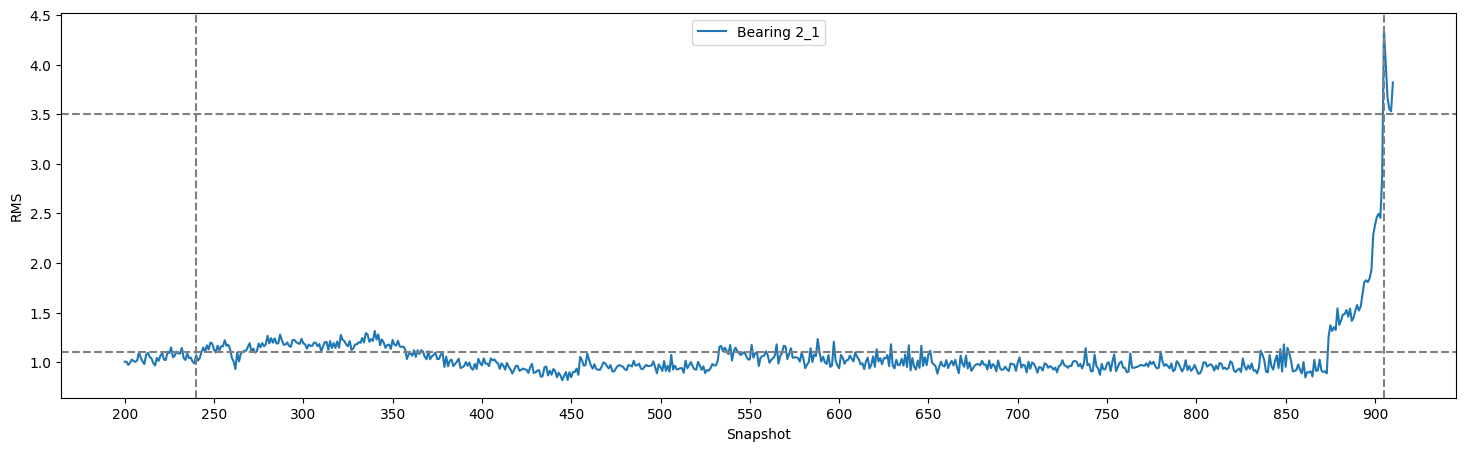

In [51]:
# Plot the RRMS values for bearing2_1 (wear-in begins from 874 to 911)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of Bearing2_1 data')
plt.xlabel("Snapshot")
plt.ylabel("RMS")
plt.plot(bearing2_1_rrms, label='Bearing2_1')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=240, linestyle='dashed', color='grey')
plt.axvline(x=905, linestyle='dashed', color='grey')
plt.xticks(np.arange(0, 911, 50))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RMS")
plt.plot(np.arange(200,911), bearing2_1_rrms[200:911], label='Bearing 2_1')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=240, linestyle='dashed', color='grey')
plt.axvline(x=905, linestyle='dashed', color='grey')
plt.xticks(np.arange(200, 911, 50))
plt.legend() 
plt.show()

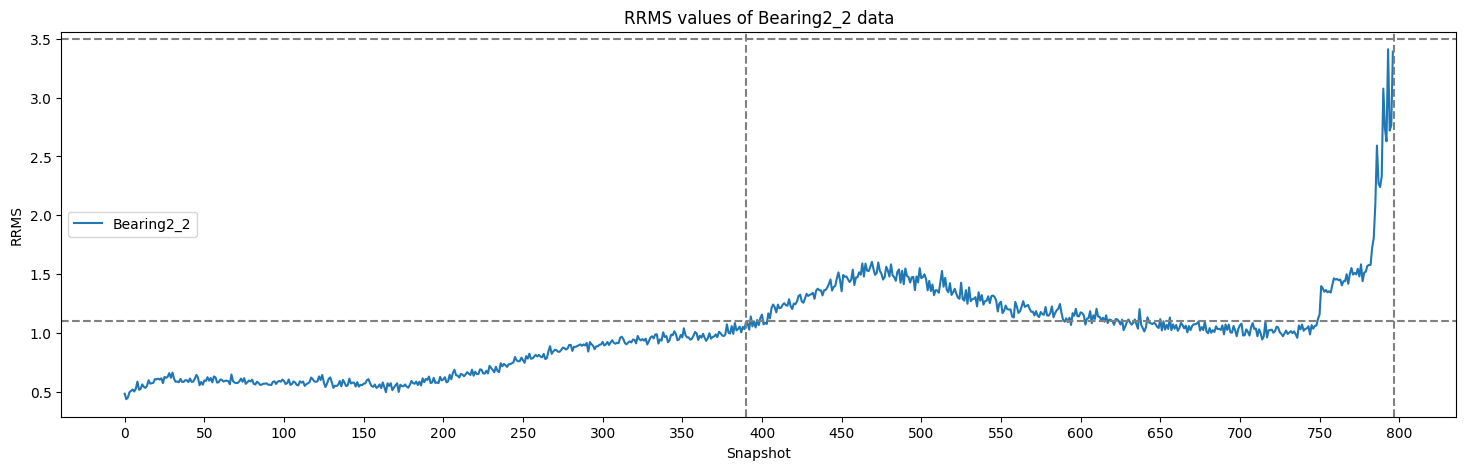

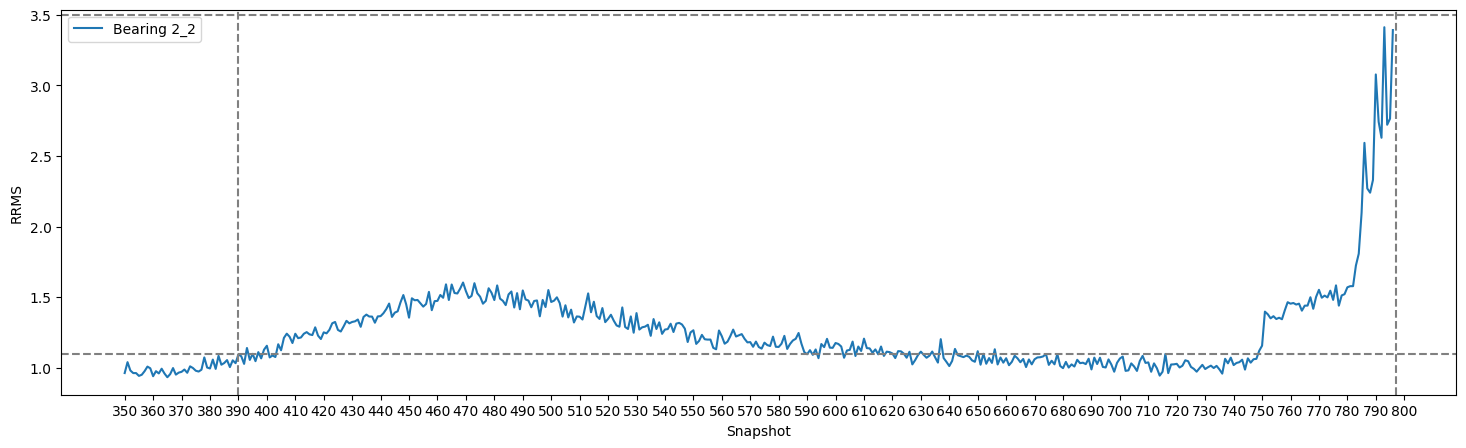

In [59]:
# Plot the RRMS values for bearing2_1 (wear-in begins from 390 to 797)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of Bearing2_2 data')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing2_2_rrms, label='Bearing2_2')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=390, linestyle='dashed', color='grey')
plt.axvline(x=797, linestyle='dashed', color='grey')
plt.xticks(np.arange(0, 801, 50))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(350,797), bearing2_2_rrms[350:797], label='Bearing 2_2')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=390, linestyle='dashed', color='grey')
plt.axvline(x=797, linestyle='dashed', color='grey')
plt.xticks(np.arange(350, 801, 10))
plt.legend() 
plt.show()

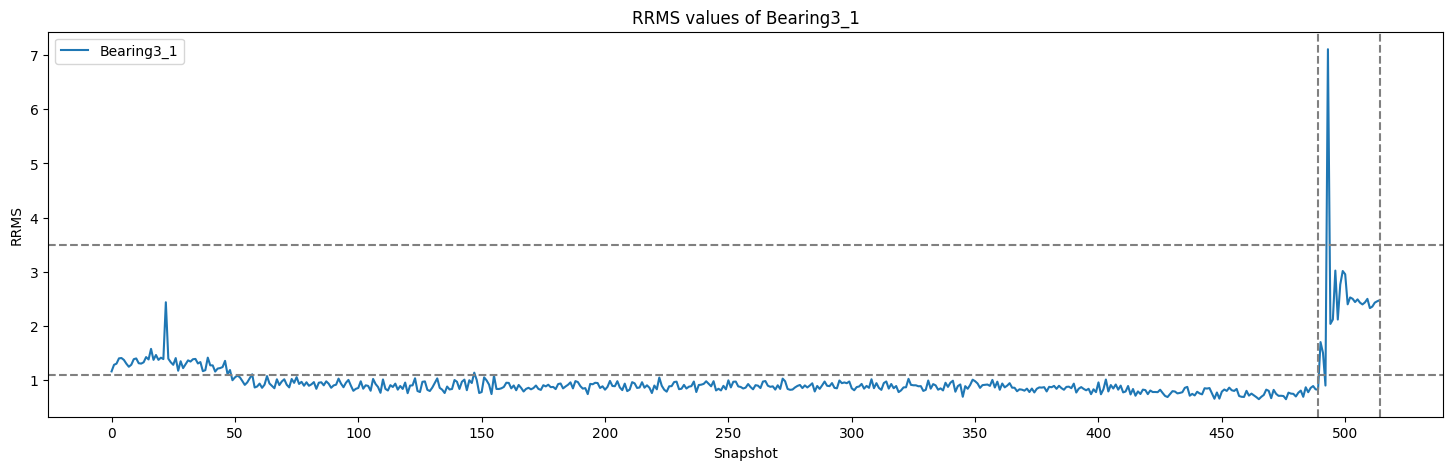

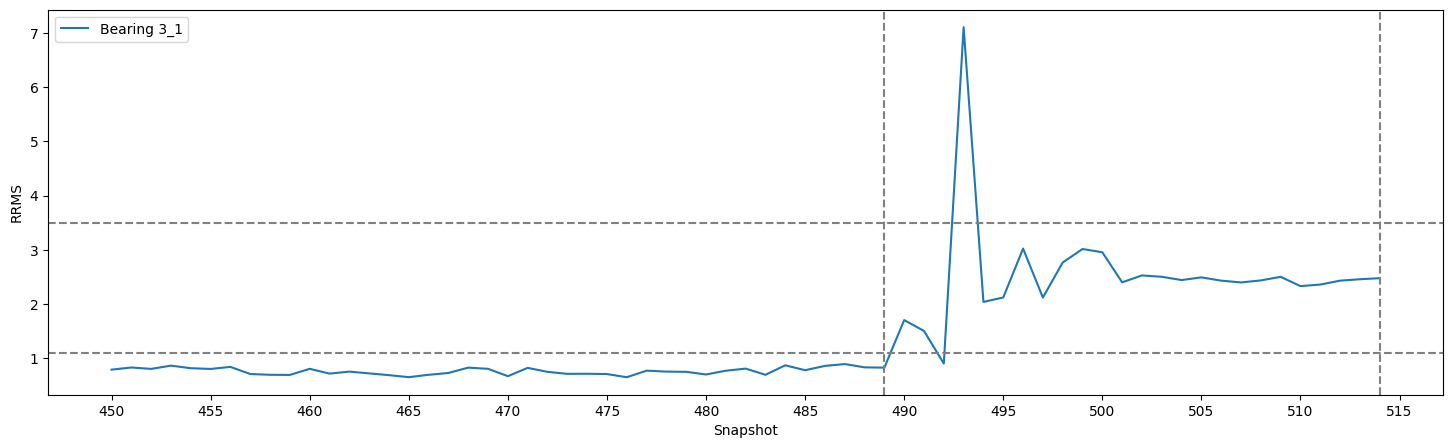

In [64]:
# Plot the RRMS values for bearing3_1 (wear-in begins from 489 to 514)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of Bearing3_1')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing3_1_rrms, label='Bearing3_1')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=489, linestyle='dashed', color='grey')
plt.axvline(x=514, linestyle='dashed', color='grey')
plt.xticks(np.arange(0, 515, 50))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(450,515), bearing3_1_rrms[450:515], label='Bearing 3_1')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=489, linestyle='dashed', color='grey')
plt.axvline(x=514, linestyle='dashed', color='grey')
plt.xticks(np.arange(450, 516, 5))
plt.legend() 
plt.show()

In [63]:
# Validation data
bearing1_3_x, bearing1_3_y = read_bearing_signal('bearing1_3')
bearing2_3_x, bearing2_3_y = read_bearing_signal('bearing2_3')
bearing3_2_x, bearing3_2_y = read_bearing_signal('bearing3_2')

bearing1_3_rms = calculate_x_y_RMS(bearing1_3_x, bearing1_3_y)
bearing2_3_rms = calculate_x_y_RMS(bearing2_3_x, bearing2_3_y)
bearing3_2_rms = calculate_x_y_RMS(bearing3_2_x, bearing3_2_y)

bearing1_3_rrms = bearing1_3_rms / bearing1_3_rms.mean()
bearing2_3_rrms = bearing2_3_rms / bearing2_3_rms.mean()
bearing3_2_rrms = bearing3_2_rms / bearing3_2_rms.mean()

bearing1_3_rrms

array([ 0.56216595,  0.52906432,  0.52638722, ..., 13.9855369 ,
       12.84976426, 12.5061355 ])

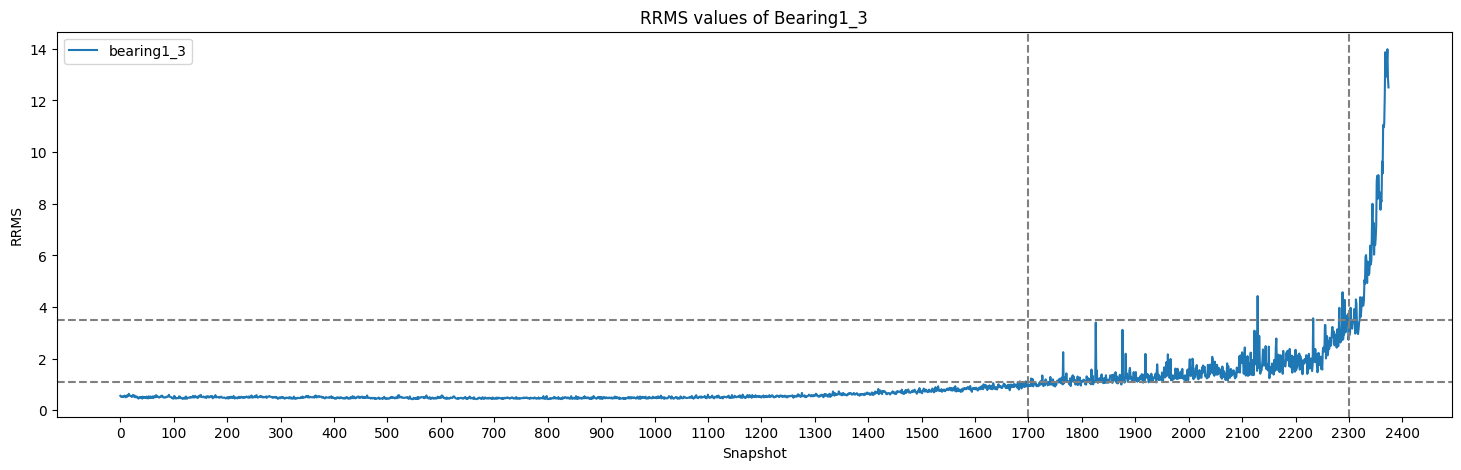

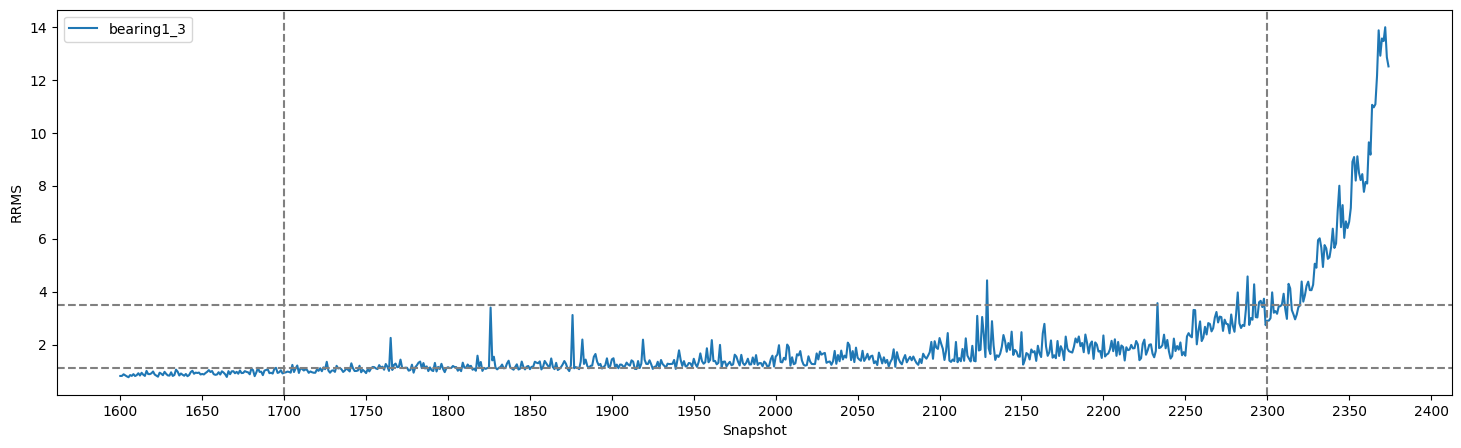

In [71]:
# Plot the RRMS values for bearing1_3 (wear-in begins from 1700 to 2300)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of Bearing1_3')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing1_3_rrms, label='bearing1_3')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1700, linestyle='dashed', color='grey')
plt.axvline(x=2300, linestyle='dashed', color='grey')
plt.xticks(np.arange(0, 2401, 100))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(1600,2375), bearing1_3_rrms[1600:2375], label='bearing1_3')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1700, linestyle='dashed', color='grey')
plt.axvline(x=2300, linestyle='dashed', color='grey')
plt.xticks(np.arange(1600, 2401, 50))
plt.legend() 
plt.show()

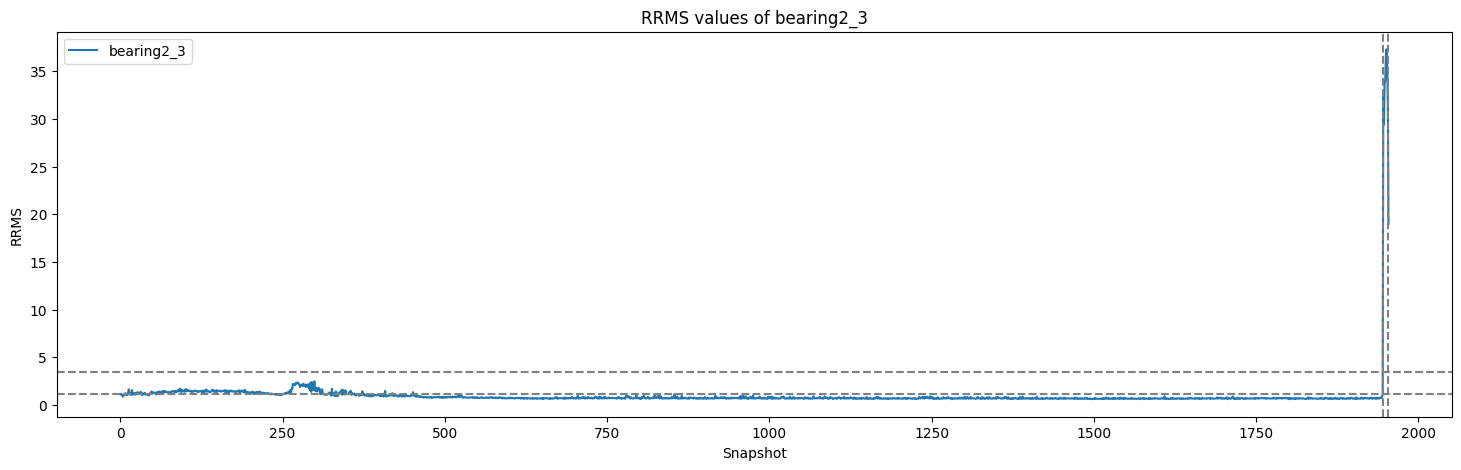

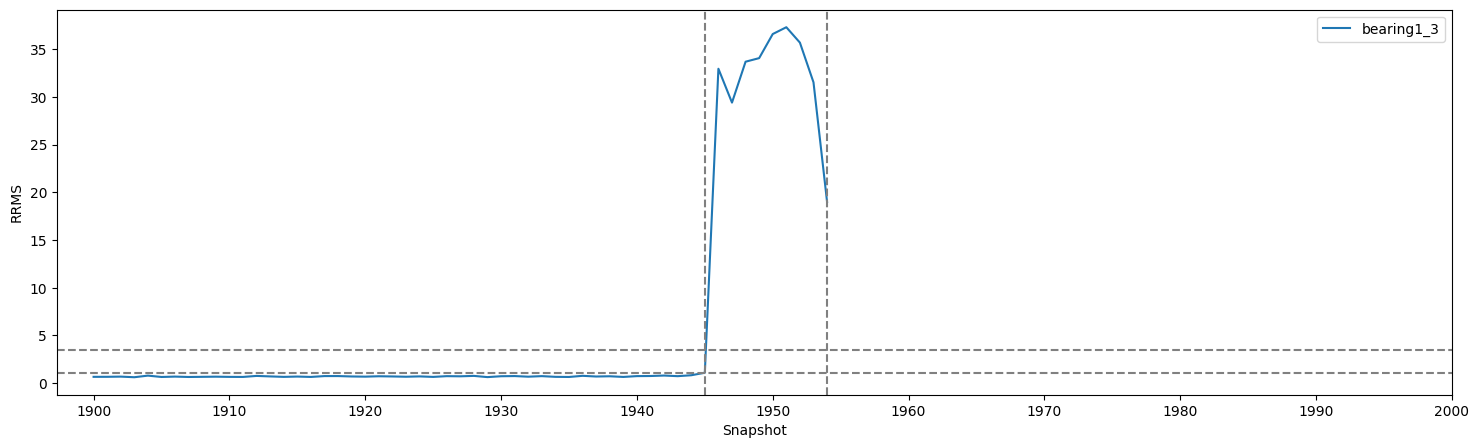

In [79]:
# Plot the RRMS values for bearing2_3 (wear-in begins from 1945 to 1954)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of bearing2_3')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing2_3_rrms, label='bearing2_3')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1945, linestyle='dashed', color='grey')
plt.axvline(x=1954, linestyle='dashed', color='grey')
# plt.xticks(np.arange(0, 2401, 100))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(1900,1955), bearing2_3_rrms[1900:1955], label='bearing1_3')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1945, linestyle='dashed', color='grey')
plt.axvline(x=1954, linestyle='dashed', color='grey')
plt.xticks(np.arange(1900, 2001, 10))
plt.legend() 
plt.show()

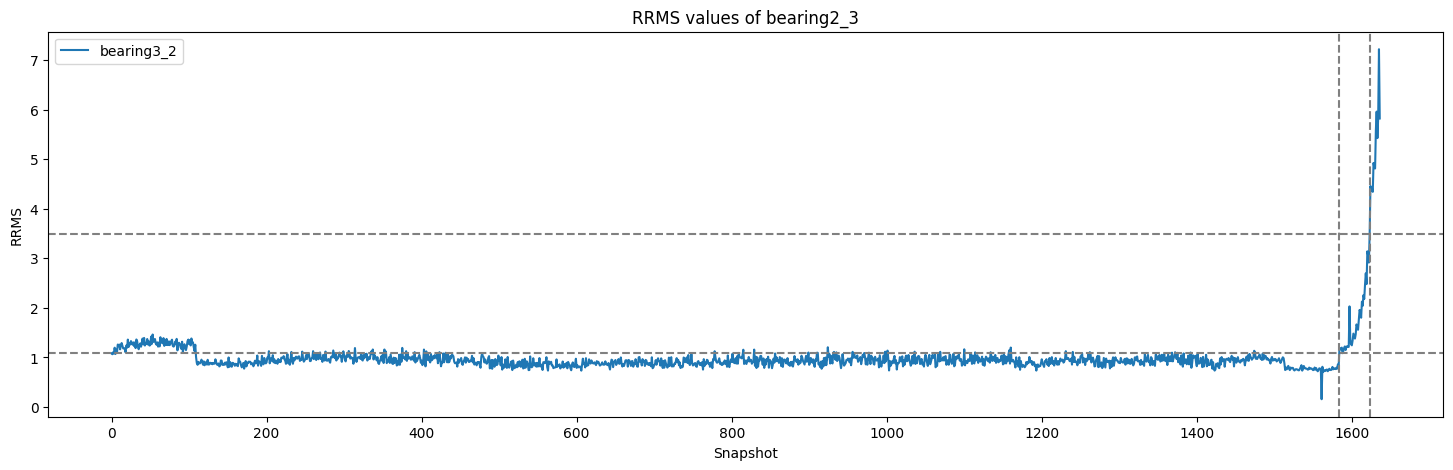

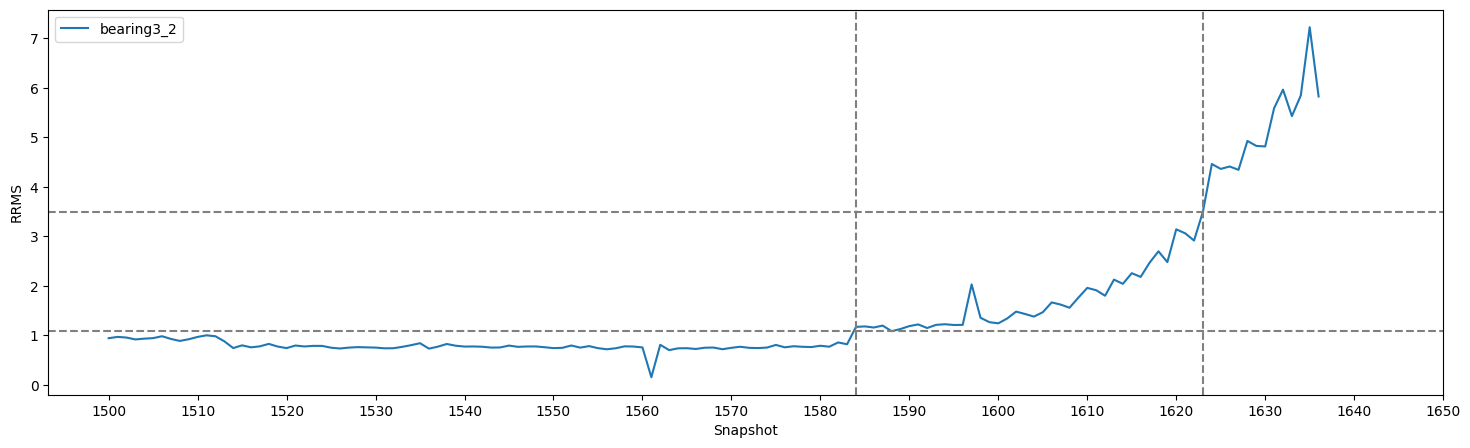

In [86]:
# Plot the RRMS values for bearing3_2 (wear-in begins from 1584 to 1623)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of bearing3_2')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing3_2_rrms, label='bearing3_2')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1584, linestyle='dashed', color='grey')
plt.axvline(x=1623, linestyle='dashed', color='grey')
# plt.xticks(np.arange(0, 2401, 100))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(1500,1637), bearing3_2_rrms[1500:1637], label='bearing3_2')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1584, linestyle='dashed', color='grey')
plt.axvline(x=1623, linestyle='dashed', color='grey')
plt.xticks(np.arange(1500, 1651, 10))
plt.legend() 
plt.show()

In [14]:
# Test data
# Test data csv are stored with ; delim. Writing a new function to read test_data
def read_test_signal(bearing_name):
    x_list, y_list = [], []
    for file_name in os.listdir(os.path.join(FEMTO_class.download_path, bearing_name)):
        if file_name[:3] == 'acc':
            x, y = get_x_y_test(bearing_name, file_name)
            x_list.append(x)
            y_list.append(x)
        
    # Convert the list into a np array
    x_signal, y_signal = np.vstack(x_list), np.vstack(y_list)
    
    return x_signal, y_signal
    
def get_x_y_test(bearing_name, file_name):
#     print(f'bearing: {bearing_name}, file: {file_name}')
    signal = pd.read_csv(os.path.join(FEMTO_class.download_path,  bearing_name, file_name), header=None)
    if len(signal.columns) == 1:
        signal = pd.read_csv(os.path.join(FEMTO_class.download_path,  bearing_name, file_name), header=None, delimiter=';')
    return np.array(signal[4]), np.array(signal[5])

In [17]:
# Test data
bearing1_4_x, bearing1_4_y = read_test_signal('bearing1_4')
bearing1_5_x, bearing1_5_y = read_test_signal('bearing1_5')
bearing1_6_x, bearing1_6_y = read_test_signal('bearing1_6')
bearing1_7_x, bearing1_7_y = read_test_signal('bearing1_7')
bearing2_4_x, bearing2_4_y = read_test_signal('bearing2_4')
bearing2_5_x, bearing2_5_y = read_test_signal('bearing2_5')
bearing2_6_x, bearing2_6_y = read_test_signal('bearing2_6')
bearing2_7_x, bearing2_7_y = read_test_signal('bearing2_7')
bearing3_3_x, bearing3_3_y = read_test_signal('bearing3_3')

bearing1_4_rms = calculate_x_y_RMS(bearing1_4_x, bearing1_4_y)
bearing1_5_rms = calculate_x_y_RMS(bearing1_5_x, bearing1_5_y)
bearing1_6_rms = calculate_x_y_RMS(bearing1_6_x, bearing1_6_y)
bearing1_7_rms = calculate_x_y_RMS(bearing1_7_x, bearing1_7_y)
bearing2_4_rms = calculate_x_y_RMS(bearing2_4_x, bearing2_4_y)
bearing2_5_rms = calculate_x_y_RMS(bearing2_5_x, bearing2_5_y)
bearing2_6_rms = calculate_x_y_RMS(bearing2_6_x, bearing2_6_y)
bearing2_7_rms = calculate_x_y_RMS(bearing2_7_x, bearing2_7_y)
bearing3_3_rms = calculate_x_y_RMS(bearing3_3_x, bearing3_3_y)


bearing1_4_rrms = bearing1_4_rms / bearing1_4_rms.mean()
bearing1_5_rrms = bearing1_5_rms / bearing1_5_rms.mean()
bearing1_6_rrms = bearing1_6_rms / bearing1_6_rms.mean()
bearing1_7_rrms = bearing1_7_rms / bearing1_7_rms.mean()
bearing2_4_rrms = bearing2_4_rms / bearing2_4_rms.mean()
bearing2_5_rrms = bearing2_5_rms / bearing2_5_rms.mean()
bearing2_6_rrms = bearing2_6_rms / bearing2_6_rms.mean()
bearing2_7_rrms = bearing2_7_rms / bearing2_7_rms.mean()
bearing3_3_rrms = bearing3_3_rms / bearing3_3_rms.mean()

bearing1_4_rrms

array([0.24383867, 0.23623275, 0.23694003, ..., 6.71280173, 6.58753751,
       5.64301982])

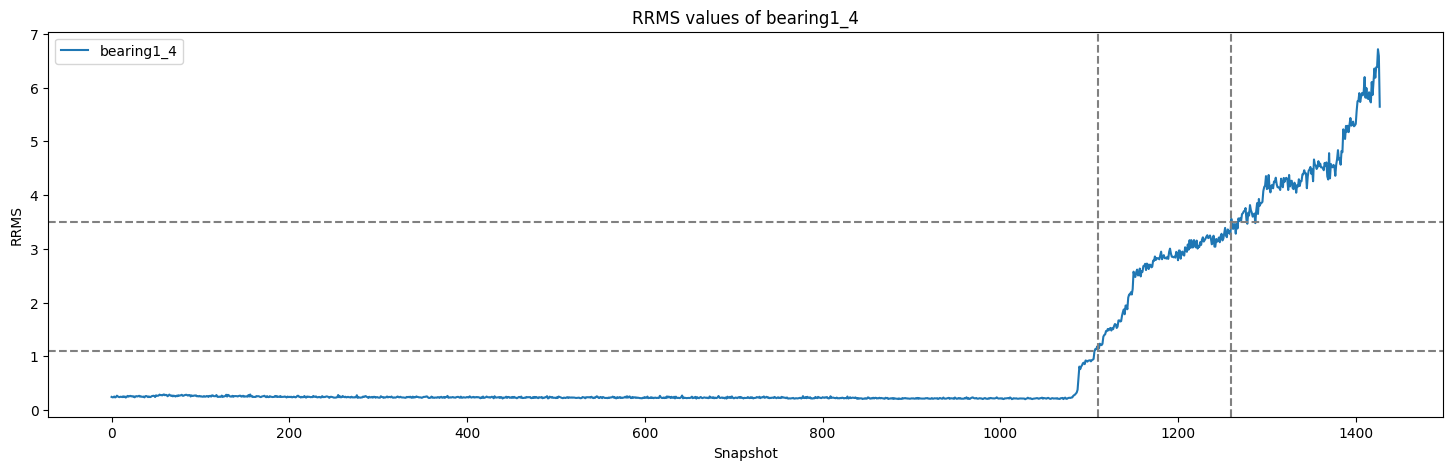

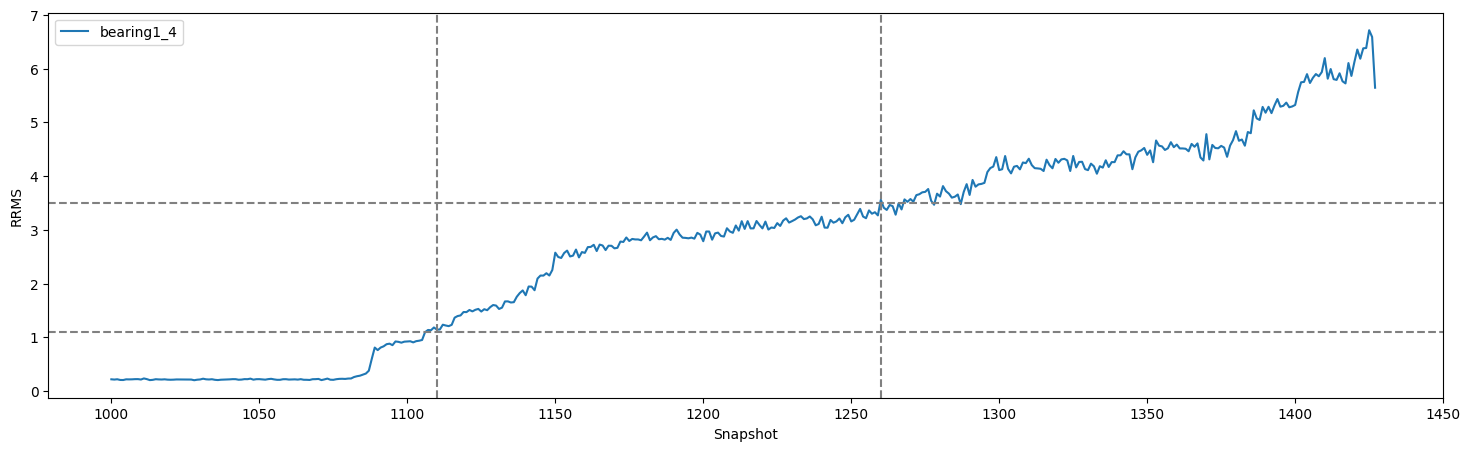

In [25]:
# Plot the RRMS values for bearing1_4 (wear-in begins from 1110 to 1260)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of bearing1_4')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing1_4_rrms, label='bearing1_4')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1110, linestyle='dashed', color='grey')
plt.axvline(x=1260, linestyle='dashed', color='grey')
# plt.xticks(np.arange(0, 2401, 100))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(1000,1428), bearing1_4_rrms[1000:1428], label='bearing1_4')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=1110, linestyle='dashed', color='grey')
plt.axvline(x=1260, linestyle='dashed', color='grey')
plt.xticks(np.arange(1000, 1451, 50))
plt.legend() 
plt.show()

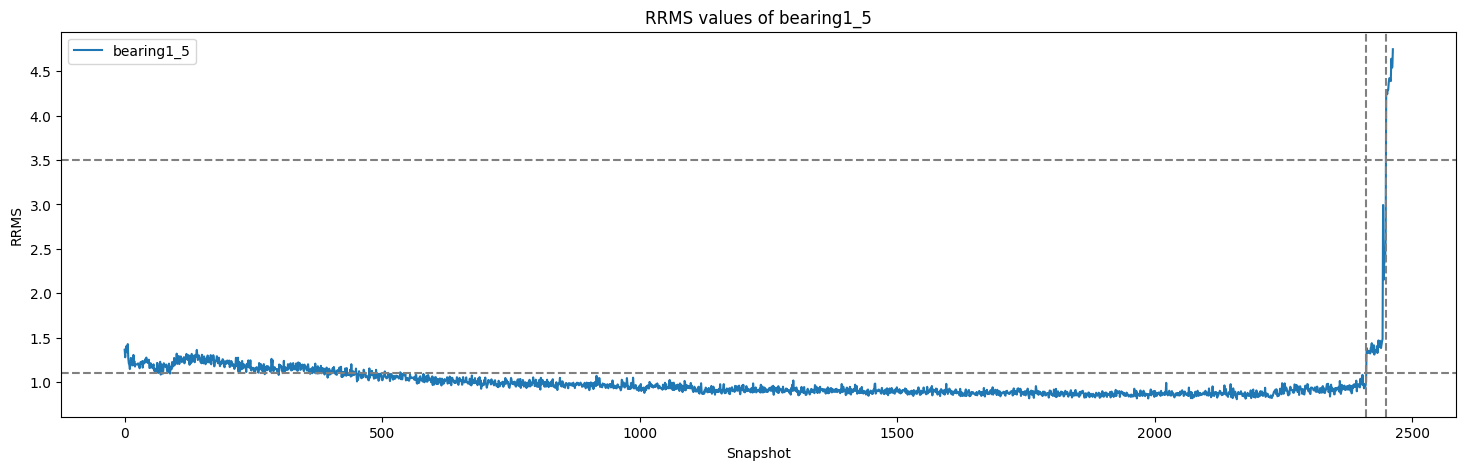

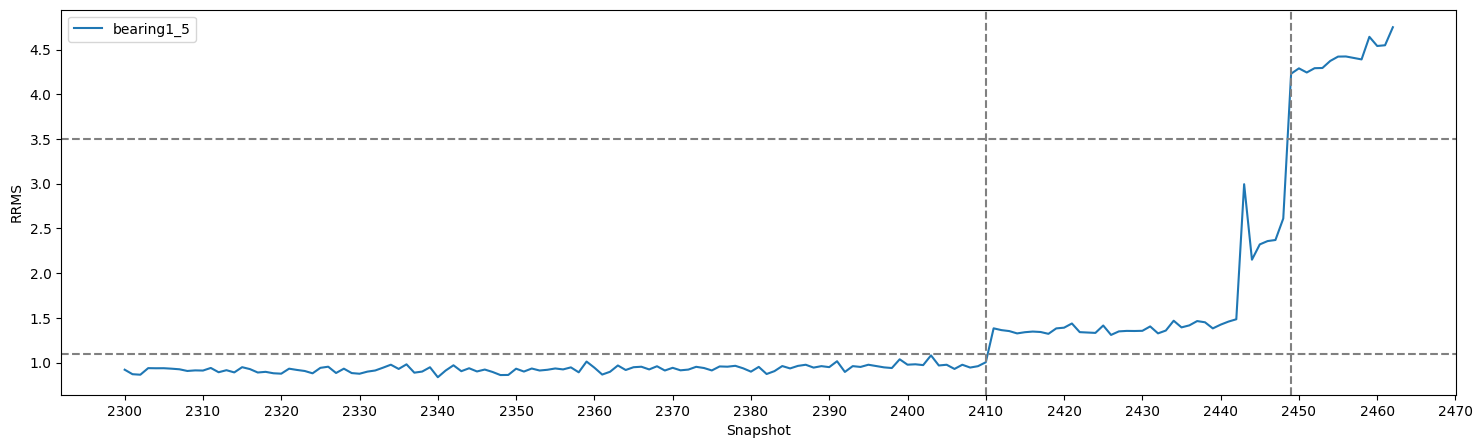

In [32]:
# Plot the RRMS values for bearing1_5 (wear-in begins from 2410 to 2449)
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of bearing1_5')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing1_5_rrms, label='bearing1_5')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=2410, linestyle='dashed', color='grey')
plt.axvline(x=2449, linestyle='dashed', color='grey')
# plt.xticks(np.arange(0, 2401, 100))
plt.legend() 
plt.show()
# Zoomed in graph
plt.figure(figsize=(18,5))
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(np.arange(2300,2463), bearing1_5_rrms[2300:2463], label='bearing1_5')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
plt.axvline(x=2410, linestyle='dashed', color='grey')
plt.axvline(x=2449, linestyle='dashed', color='grey')
plt.xticks(np.arange(2300, 2471, 10))
plt.legend() 
plt.show()

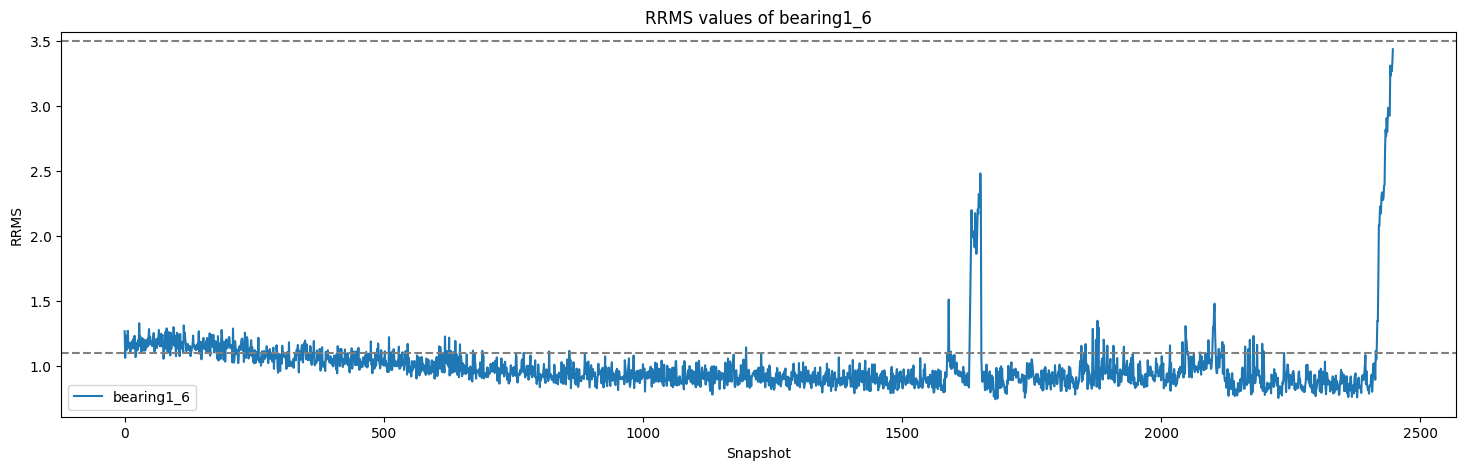

In [33]:
# Plot the RRMS values for bearing1_6 (wear-in begins from  to )
plt.figure(figsize=(18,5))
plt.title(f'RRMS values of bearing1_6')
plt.xlabel("Snapshot")
plt.ylabel("RRMS")
plt.plot(bearing1_6_rrms, label='bearing1_6')
plt.axhline(y=1.1, linestyle='dashed', color='grey')
plt.axhline(y=3.5, linestyle='dashed', color='grey')
# plt.axvline(x=2410, linestyle='dashed', color='grey')
# plt.axvline(x=2449, linestyle='dashed', color='grey')
# plt.xticks(np.arange(0, 2401, 100))
plt.legend() 
plt.show()
# Zoomed in graph
# plt.figure(figsize=(18,5))
# plt.xlabel("Snapshot")
# plt.ylabel("RRMS")
# plt.plot(np.arange(2300,2463), bearing1_5_rrms[2300:2463], label='bearing1_5')
# plt.axhline(y=1.1, linestyle='dashed', color='grey')
# plt.axhline(y=3.5, linestyle='dashed', color='grey')
# plt.axvline(x=2410, linestyle='dashed', color='grey')
# plt.axvline(x=2449, linestyle='dashed', color='grey')
# plt.xticks(np.arange(2300, 2471, 10))
# plt.legend() 
# plt.show()